# PCA, Gaussian and MoG models

## PCA

The PCA assumes gaussianity of the data distribution.

The PCA has a connectionist interpretation/representation:

<img src="images/pca.jpg" width="500pt"/>

Let's review the classic geometric interpretation applied to the MNIST dataset:

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# Loading the data:
(y_train, _), (y_test, _) = mnist.load_data()
y_train = np.reshape(y_train,(y_train.shape[0],28*28))
y_test = np.reshape(y_test,(y_test.shape[0],28*28))
print(y_train.shape)
print(y_test.shape)

(60000, 784)
(10000, 784)


(10000, 784)
(784,)
(784, 784)


Text(0.5, 1.0, 'Singular values')

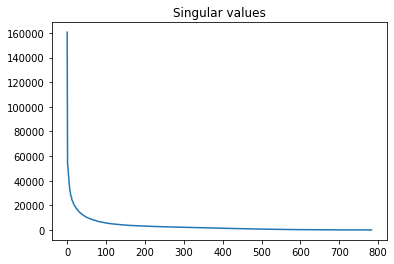

In [2]:
# Decomposition to get the eigenvectors of the covariance matrix:
y_test_mean = np.mean(y_test, axis=0)
y_test_centered = y_test - y_test_mean
U,S,V = np.linalg.svd(y_test,
                     full_matrices=False,
                     compute_uv=True)
print(U.shape)
print(S.shape)
print(V.shape)

# The singular values:
plt.figure()
plt.plot(S)
plt.title('Singular values')

(10000, 64)
(64,)
(64, 784)


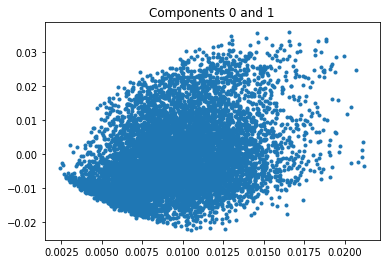

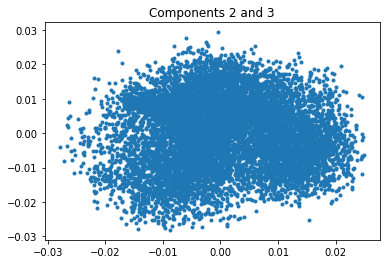

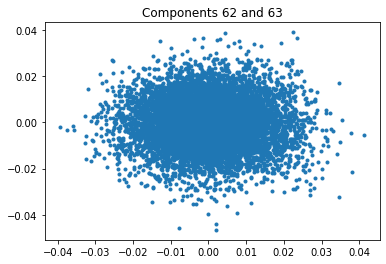

In [3]:
# Retaining only some components:
d = 64
U = U[:,0:d]
S = S[0:d]
V = V[0:d,:]
print(U.shape)
print(S.shape)
print(V.shape)

# Being A = U S V' => A V S^-1 = U ...
# ... then the coefficients in U are samples from as isotropic normal distribution:
def plot_components(i,j):
    plt.figure()
    plt.plot(U[:,i],U[:,j],'.')
    plt.title('Components %d and %d' % (i,j))

plot_components(0,1)
plot_components(2,3)
plot_components(62,63)

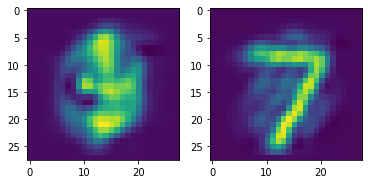

In [4]:
# The underlying distribution is not Gaussian...
# ...but let's try to sample it:

def reconstruct_image(coefs):
    return np.reshape((coefs*S).dot(V) + y_test_mean,(28,28))

coefs = np.random.normal(0,0.01,(d,))
plt.subplot(1,2,1);
plt.imshow(reconstruct_image(coefs))

coefs = U[0,:]
plt.subplot(1,2,2);
plt.imshow(reconstruct_image(coefs));

The PCA seams to be a poor model for the MNIST dataset.

The data seams to be distributed more like a Mixture of Gaussians (MoG).

## MoG (GMM)

The MoG assumes a mixture of __k gaussian distributions__.

A _latent variable_ $i\sim\pi$ chooses the gaussian $N_i \equiv (\mu_i,\Lambda_i)$.

Also the MoG can be represented as a graphical model:

<img src="images/mog.png" width="500pt"/>

To sample from it __first__ sample $i$ from $\pi$, than sample from $N_i$.

In [5]:
# Loading the tools:
%run GMM.py

# Applying the EM for gaussians to the data:
gmm = GMM(k=10)
gmm.fit(U[0:10000:10,:], max_iters=10)

Iteration 1: log-likelihood is 200579.726357
Iteration 2: log-likelihood is 208418.283302
Iteration 3: log-likelihood is 220625.426814
Iteration 4: log-likelihood is 238167.129878
Iteration 5: log-likelihood is 221156.466171
Terminate at 5-th iteration:log-likelihood is 221156.466171


In [6]:
# Preparing the distributions:
pi = stats.rv_discrete(values=(range(gmm.phi.shape[0]),gmm.phi))
N = lambda i: stats.multivariate_normal.rvs(
    mean=np.squeeze(np.asarray(gmm.mean_arr[i])),
    cov=np.squeeze(np.asarray(gmm.sigma_arr[i])))

# Sampling from this distribution:
def gmm_sample():
    # Choosing the gaussian:
    i = pi.rvs()
    
    # Sampling from it:
    return N(i)

<ipython-input-7-6cc9f857d676>:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n, m, c + 1)


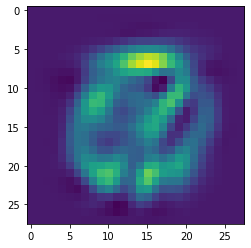

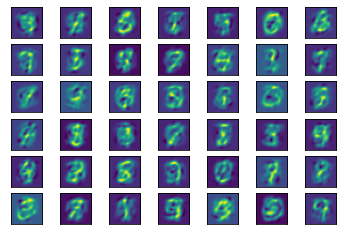

In [7]:
def imshowgrid(imgs):
    tot = len(imgs)
    m = np.ceil(np.sqrt(tot))
    n = np.ceil(tot/m)
    plt.figure()
    for c in range(tot):
        ax = plt.subplot(n, m, c + 1)
        plt.imshow(imgs[c])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Showing samples:
plt.imshow(reconstruct_image(gmm_sample()))
imshowgrid([reconstruct_image(gmm_sample()) for _ in range(42)]);

Hard to capture the shape of the underlying distribution...

...can try with much more gaussians in the mixture...

...must try with a NN!